In [118]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import r2_score
import itertools
import time
import statsmodels.formula.api as smf

train = pd.read_csv('ncaa_train.csv')
test = pd.read_csv('ncaa_test.csv')
alldata = pd.concat([train,test])
alldata['indx'] = [i for i in range(61)]
alldata = alldata.set_index(keys=['indx'])

In [30]:
#Forward Stepwise Selection
#Creating a set of predictors from which we need to find the best subset of predictors
X = train[['GP', 'GS', 'MIN', 'PTS', 'FGM', 'FGA', 'FGP', 'Three_Pmade',
       'Three_PA', 'Three_PP', 'FTM', 'FTA', 'FTP', 'OFF', 'DEF', 'TRB', 'AST',
       'STL', 'BLK', 'TOV', 'PF']]
#Function to develop a model based on all predictors in predictor_subset
def processSubset(predictor_subset):
    # Fit model on feature_set and calculate R-squared
    model = sm.ols('NBA_PTS~' + '+'.join(predictor_subset),data = train).fit()
    Rsquared = model.rsquared
    return {"model":model, "Rsquared":Rsquared}
#Function to find the best predictor out of p-k predictors and add it to the model containing the k predictors
def forward(predictors):

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X.columns if p not in predictors]
    
    tic = time.time()
    
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p]))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['Rsquared'].argmax()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [31]:
def forward_selection():
    models_best = pd.DataFrame(columns=["Rsquared", "model"])

    tic = time.time()
    predictors = []

    for i in range(1,len(X.columns)+1):    
        models_best.loc[i] = forward(predictors)
        predictors = list(models_best.loc[i]["model"].params.index[1:])

    toc = time.time()
    print("Total elapsed time:", (toc-tic), "seconds.")
    return models_best

models_best = forward_selection()

Processed  21 models on 1 predictors in 0.1763598918914795 seconds.
Processed  20 models on 2 predictors in 0.5747358798980713 seconds.
Processed  19 models on 3 predictors in 0.2503812313079834 seconds.
Processed  18 models on 4 predictors in 0.32498812675476074 seconds.
Processed  17 models on 5 predictors in 0.2670600414276123 seconds.
Processed  16 models on 6 predictors in 0.29497289657592773 seconds.
Processed  15 models on 7 predictors in 0.18003416061401367 seconds.
Processed  14 models on 8 predictors in 0.23949694633483887 seconds.
Processed  13 models on 9 predictors in 0.26439714431762695 seconds.
Processed  12 models on 10 predictors in 0.19645380973815918 seconds.
Processed  11 models on 11 predictors in 0.20139002799987793 seconds.
Processed  10 models on 12 predictors in 0.20203089714050293 seconds.
Processed  9 models on 13 predictors in 0.34265899658203125 seconds.
Processed  8 models on 14 predictors in 0.3214108943939209 seconds.
Processed  7 models on 15 predictors

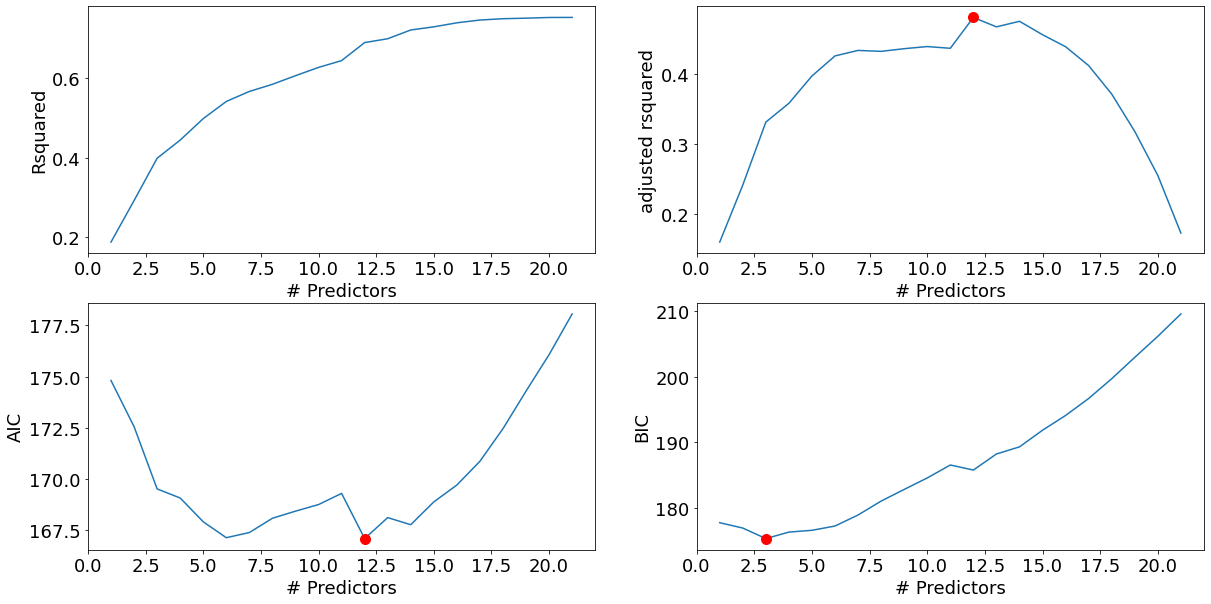

In [32]:
def best_sub_plots():
    plt.figure(figsize=(20,10))
    plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

    # Set up a 2x2 grid so we can look at 4 plots at once
    plt.subplot(2, 2, 1)

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector
    plt.plot(models_best["Rsquared"])
    plt.xlabel('# Predictors')
    plt.ylabel('Rsquared')

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector

    rsquared_adj = models_best.apply(lambda row: row[1].rsquared_adj, axis=1)

    plt.subplot(2, 2, 2)
    plt.plot(rsquared_adj)
    plt.plot(1+rsquared_adj.argmax(), rsquared_adj.max(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('adjusted rsquared')

    # We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
    aic = models_best.apply(lambda row: row[1].aic, axis=1)

    plt.subplot(2, 2, 3)
    plt.plot(aic)
    plt.plot(1+aic.argmin(), aic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('AIC')

    bic = models_best.apply(lambda row: row[1].bic, axis=1)

    plt.subplot(2, 2, 4)
    plt.plot(bic)
    plt.plot(1+bic.argmin(), bic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('BIC')
best_sub_plots()

In [33]:
best_fwd_reg_model = models_best['model'][12]
best_fwd_reg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                NBA_PTS   R-squared:                       0.689
Model:                            OLS   Adj. R-squared:                  0.481
Method:                 Least Squares   F-statistic:                     3.320
Date:                Thu, 09 Mar 2023   Prob (F-statistic):             0.0108
Time:                        21:24:30   Log-Likelihood:                -70.544
No. Observations:                  31   AIC:                             167.1
Df Residuals:                      18   BIC:                             185.7
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     -25.1311      9.068     -2.771      0.013     -44.183      -6.079
GS              0.4274      0.118      3.636      0.002       0.180       0.674
OFF            -4.3519      1.786     -2.437      0.025      -8.104      -0.599
BLK             4.3527      2.476      1.758      0.096      -0.849       9.555
FTP            16.7223     10.021      1.669      0.112      -4.331      37.775
TOV             2.7456      1.281      2.144      0.046       0.055       5.436
AST            -0.9501      0.530     -1.794      0.090      -2.063       0.163
FGP            15.1458      8.288      1.828      0.084      -2.266      32.557
TRB             0.6107      0.608      1.004      0.329      -0.668       1.889
STL             1.3310      2.095      0.635      0.533      -3.070       5.732
Three_Pmade    -7.6044      3.766     -2.019      0.059     -15.518       0.309
Three_PA        2.8097      1.614      1.741      0.099      -0.580       6.200
FTA            -0.9545      0.590     -1.617      0.123      -2.195       0.285
==============================================================================
Omnibus:                        3.738   Durbin-Watson:                   1.596
Prob(Omnibus):                  0.154   Jarque-Bera (JB):                2.265
Skew:                          -0.565   Prob(JB):                        0.322
Kurtosis:                       3.691   Cond. No.                         613.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [35]:
ols_object = smf.ols(formula = 'NBA_PTS~GS+OFF+BLK+FTP+TOV+AST+FGP+TRB+STL+Three_Pmade+Three_PA+FTA', data = train)
model = ols_object.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                NBA_PTS   R-squared:                       0.689
Model:                            OLS   Adj. R-squared:                  0.481
Method:                 Least Squares   F-statistic:                     3.320
Date:                Thu, 09 Mar 2023   Prob (F-statistic):             0.0108
Time:                        21:25:40   Log-Likelihood:                -70.544
No. Observations:                  31   AIC:                             167.1
Df Residuals:                      18   BIC:                             185.7
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     -25.1311      9.068     -2.771      0.013     -44.183      -6.079
GS              0.4274      0.118      3.636      0.002       0.180       0.674
OFF            -4.3519      1.786     -2.437      0.025      -8.104      -0.599
BLK             4.3527      2.476      1.758      0.096      -0.849       9.555
FTP            16.7223     10.021      1.669      0.112      -4.331      37.775
TOV             2.7456      1.281      2.144      0.046       0.055       5.436
AST            -0.9501      0.530     -1.794      0.090      -2.063       0.163
FGP            15.1458      8.288      1.828      0.084      -2.266      32.557
TRB             0.6107      0.608      1.004      0.329      -0.668       1.889
STL             1.3310      2.095      0.635      0.533      -3.070       5.732
Three_Pmade    -7.6044      3.766     -2.019      0.059     -15.518       0.309
Three_PA        2.8097      1.614      1.741      0.099      -0.580       6.200
FTA            -0.9545      0.590     -1.617      0.123      -2.195       0.285
==============================================================================
Omnibus:                        3.738   Durbin-Watson:                   1.596
Prob(Omnibus):                  0.154   Jarque-Bera (JB):                2.265
Skew:                          -0.565   Prob(JB):                        0.322
Kurtosis:                       3.691   Cond. No.                         613.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [37]:
pred_pts = model.predict(test)
print("RMSE: " + str(np.sqrt(((test.NBA_PTS - pred_pts)**2).mean())))
print("RSE: " + str(np.sqrt(model.mse_resid)))

RMSE: 7.194775011086357
RSE: 3.090946618717701


In [170]:
alldata = pd.concat([train,test])
alldata['indx'] = [i for i in range(61)]
alldata = alldata.set_index(keys=['indx'])
train_newz = alldata.iloc[0:49]
test_newz = alldata.iloc[49:61]

In [171]:
y = train_newz.NBA_PTS
X = train_newz.loc[:,['GS','OFF','BLK','FTP','TOV','AST','FGP','TRB','STL','Three_Pmade','Three_PA','FTA']]; 

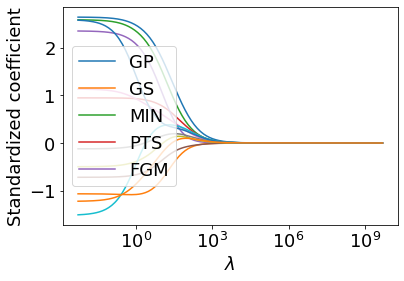

In [173]:
#y = np.log(train.NBA_PTS)

#Defining a scaler object
scaler = StandardScaler()

#The scaler object will contain the mean and variance of each column (predictor) of X. 
#These values will be useful to scale test data based on the same mean and variance as obtained on train data
scaler.fit(X)

#Using the scaler object (or the values of mean and variance stored in it) to standardize X (or train data)
Xstd = scaler.transform(X)

alphas = 10**np.linspace(10,-2,200)*0.5

coefs = []
for a in alphas:        
    ridge = Ridge(alpha = a)
    ridge.fit(Xstd, y)
    coefs.append(ridge.coef_)
    
#Visualizing the shrinkage in ridge regression coefficients with increasing values of the tuning parameter lambda
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=18)
plt.plot(alphas, coefs)
plt.xscale('log')
plt.xlabel('$\lambda$')
plt.ylabel('Standardized coefficient')
plt.legend(train_newz.columns[1:6]);

In [174]:
alphas = 10**np.linspace(1.5,-3,200)*0.5
ridgecv = RidgeCV(alphas = alphas,store_cv_values=True)
ridgecv.fit(Xstd, y)

#Optimal value of the tuning parameter - lambda
ridgecv.alpha_

/Users/pranavdoradla/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:1791: RuntimeWarning: invalid value encountered in reciprocal
  w = ((singvals_sq + alpha) ** -1) - (alpha ** -1)


7.627585592702987

Text(0, 0.5, 'Cross-validation error')

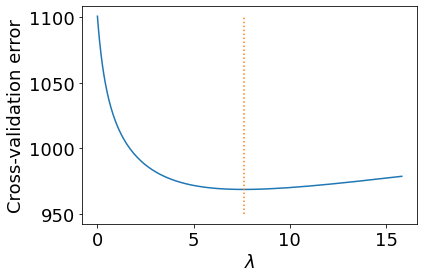

In [177]:
#Visualizing the LOOCV (leave one out cross validatation error vs lambda)
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=18)
plt.plot(ridgecv.alphas,ridgecv.cv_values_.sum(axis=0))
plt.plot([ridgecv.alpha_,ridgecv.alpha_],[950,1100],':')
plt.xlabel('$\lambda$')
plt.ylabel('Cross-validation error')

In [178]:
Xtest = test_newz.loc[:,['GS','OFF','BLK','FTP','TOV','AST','FGP','TRB','STL','Three_Pmade','Three_PA','FTA']]

#Standardizing test data
Xtest_std = scaler.transform(Xtest)

#Using the developed ridge regression model to predict on test data
ridge = Ridge(alpha = ridgecv.alpha_)
ridge.fit(Xstd, y)
pred=ridge.predict(Xtest_std)

#RMSE on test data
#np.sqrt(((np.exp(pred)-test.NBA_PTS)**2).mean())
np.sqrt(((pred-test_newz.NBA_PTS)**2).mean())

6.774112907419319

In [179]:
r2_score(pred,test_newz.NBA_PTS)

-1.3573114169446305

In [79]:
from sklearn.model_selection import KFold

In [80]:
kf = KFold(n_splits = 6)
kf.get_n_splits(alldata)

6

In [106]:
sel_ints = str()
for i in selected_interactions:
    sel_ints += "+" + i
sel_ints[1:]


'Player+GP+GS+MIN+PTS+FGM+FGA+FGP+Three_Pmade+Three_PA+Three_PP+FTM+FTA+FTP+OFF+DEF+TRB+AST+STL+BLK+TOV+PF+NBA_PTS'

In [113]:
# Fill out this function - that is all you need to do to make the code work!

# The function must return the mean 5-fold cross validation RMSE for the model
# that has the 'selected_interactions', and the 'interaction_being_tested'
def KFoldCV(selected_interactions, interaction_being_tested=None):
    sel_ints = str()
    for i in selected_interactions:
        sel_ints += "+" + i
    sel_ints = sel_ints[1:]
    for i, (train_index, test_index) in enumerate(kf.split(alldata)):
        model_kf = sm.ols('NBA_PTS~'+sel_ints+interaction_being_tested, data = alldata.iloc[train_index]).fit()
        pred_pts_kf = model_kf.predict(alldata.iloc[test_index])
        rmse = np.sqrt(((alldata.NBA_PTS - pred_pts_kf)**2).mean())
    return(0)

In [114]:
def KFoldCV(selected_interactions, interaction_being_tested):
        rmses = []
        for i in range(k):
            group = np.arange(i*fold_size,(i+1)*fold_size)
            tests = train.loc[group,:]
            trains = train.drop(group)
            model = smf.ols('hi_int_prncp_pd~num_sats + int_rate+loan_amnt+out_prncp_inv'+selected_interactions+interaction_being_tested, data = trains).fit()
            pred=model.predict(tests)
            rmses.append(np.sqrt(((pred-tests.hi_int_prncp_pd)**2).mean()))
            
        return sum(rmses) / len(rmses)

In [115]:
predictor_set = list(alldata.columns)

In [116]:
# This code implements the algorithm of systematically considering interactions of degree 2 and going upto 
# the interaction of degree 12
history=[]

selected_interactions = predictor_set
cv_previous_model = KFoldCV(selected_interactions = selected_interactions, interaction_being_tested = None)
history.append([cv_previous_model, ",".join(selected_interactions)])

print("Initially, RMSE={}, features={}".format(cv_previous_model, selected_interactions))

candidates = [col for col in train.columns if col not in predictor_set +['price']]

for interaction_being_tested in tqdm(candidates):
  cv=KFoldCV(selected_interactions.copy(), interaction_being_tested)
  if cv<cv_previous_model:
    selected_interactions.append(interaction_being_tested)
    cv_previous_model=cv 
    history.append([cv_previous_model, ",".join(selected_interactions)])

NameError: name 'k' is not defined

In [135]:
kfold_model = sm.ols(formula = 'NBA_PTS~GS+OFF+TOV+GS*TOV', data=train).fit()
kfold_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                NBA_PTS   R-squared:                       0.398
Model:                            OLS   Adj. R-squared:                  0.306
Method:                 Least Squares   F-statistic:                     4.300
Date:                Sun, 12 Mar 2023   Prob (F-statistic):            0.00839
Time:                        18:50:20   Log-Likelihood:                -80.768
No. Observations:                  31   AIC:                             171.5
Df Residuals:                      26   BIC:                             178.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.7002      7.446      1.706      0.100      -2.604      28.005
GS            -0.2502      0.307     -0.815      0.422      -0.881       0.381
OFF           -2.3707      1.270     -1.866      0.073      -4.982       0.240
TOV           -4.4396      2.913     -1.524      0.140     -10.427       1.548
GS:TOV         0.2335      0.124      1.888      0.070      -0.021       0.488
==============================================================================
Omnibus:                        1.511   Durbin-Watson:                   1.281
Prob(Omnibus):                  0.470   Jarque-Bera (JB):                0.550
Skew:                           0.219   Prob(JB):                        0.760
Kurtosis:                       3.483   Cond. No.                         779.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [154]:
#K-fold Model RMSE
predsK = kfold_model.predict(test)
actuals = test[['NBA_PTS']]
actuals = actuals.iloc[:,0]
print('RMSE = ', np.sqrt(((predsK - actuals)**2).mean()))
#K-fold model RSE
print('RSE = ',np.sqrt(kfold_model.mse_resid))

RMSE =  5.848066627524106
RSE =  3.5766315522885432


In [180]:
out = kfold_model.outlier_test()

In [181]:
np.sum((np.abs(out.student_resid)>3))

0

In [166]:
#Setting the seed as we are shuffling the data before splitting it into K-folds
np.random.seed(123)
# Shuffling the training set before creating K folds
alldata = alldata.sample(frac=1)
k = 60 #5-fold cross validation
fold_size = np.round(alldata.shape[0]/k)

In [167]:
def KFoldCVAllData():
    array_new1 = [None]*k
    for i in range(k):
        dropped = np.arange(i*fold_size, (i+1)*fold_size)
        test_new = alldata.loc[dropped,:]
        train_new = alldata.drop(dropped)
        model = sm.ols('NBA_PTS~GS+OFF+TOV+GS*TOV', data = train_new).fit()
        pred = model.predict(test_new)
        array_new1[i] = np.sqrt(((test_new.NBA_PTS - pred)**2).mean())
    return np.mean(array_new1)# mean of array_new1

In [168]:
KFoldCVAllData()

3.830008257470188